In [1]:
# setting data paths for train and test data
from pathlib import Path

data_path = Path("scenes")
train_dir = data_path / "seg_train"
test_dir = data_path / "seg_test"

train_dir, test_dir

(WindowsPath('scenes/seg_train'), WindowsPath('scenes/seg_test'))

In [2]:
# creating simple transform to load and visualize data
from torchvision import transforms

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [4]:
# setting up the directories and creating dataloaders
from modules import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, 
                                                                               batch_size=16, transform=manual_transforms)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f38fab4d90>,
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

In [5]:
x_batch, y_batch = next(iter(train_dataloader))

x_batch.shape, y_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [7]:
image, label = x_batch[0], y_batch[0]

image.shape, label, class_names[label]

(torch.Size([3, 224, 224]), tensor(4), 'sea')

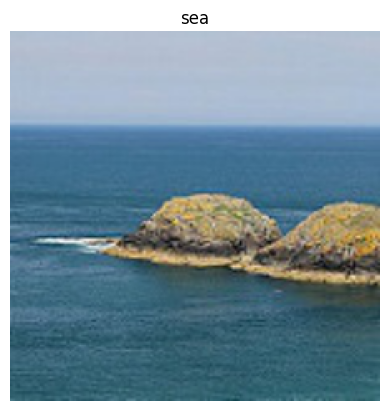

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label]);

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


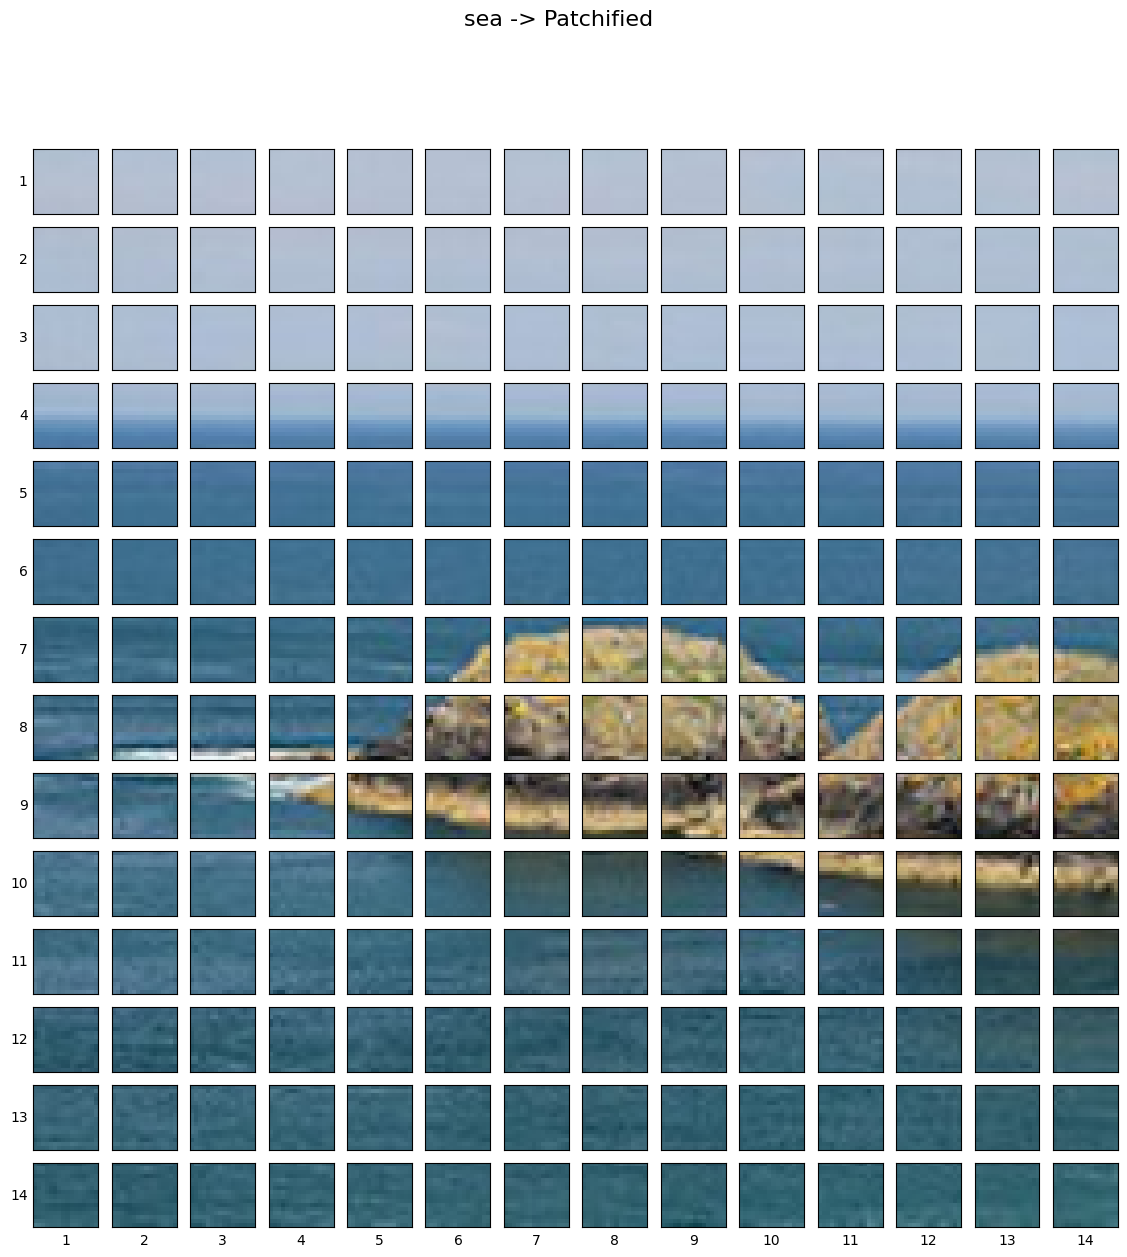

In [13]:
# creating patches
img_size = 224
patch_size = 16
N = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {N}\
        \nNumber of patches per column: {N}\
        \nTotal patches: {N*N}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")
image_permuted = image.permute(1, 2, 0)
fig, axis = plt.subplots(nrows=int(img_size/patch_size), ncols=int(img_size/patch_size), figsize=(N, N), sharex=True, sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axis[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        axis[i,j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
        axis[i,j].set_xlabel(j+1)
        axis[i,j].set_xticks([])
        axis[i,j].set_yticks([])
        axis[i, j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [19]:
# creating patches with convolution layer

from torch import nn

conv_layer = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)

image.shape

torch.Size([3, 224, 224])

In [20]:
# since convolution takes imagesize = (batch_size, C, H, W), we need to add 1 dim
image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [21]:
convolved_img = conv_layer(image.unsqueeze(0))
convolved_img.shape

torch.Size([1, 768, 14, 14])

392


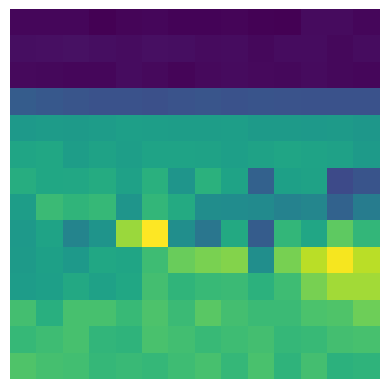

In [38]:
# visualizing random feature maps
import random
import numpy

random_idx = random.randint(0, 768)
print(random_idx)
plt.imshow(convolved_img[:, random_idx, :, :].squeeze().detach().numpy()) # detach removes the requires_grad part
plt.axis(False);

In [58]:
# Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]
# Converting feature map to 1D embeddings

flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_img = flatten_layer(convolved_img)
flatten_img.shape

torch.Size([1, 768, 196])

In [40]:
# Current tensor shape: torch.Size([1, 768, 196]) -> [batch, embedding_dim, num_patches]
# Rearranging it to our required format of [batch, num_patches, embedding_dim]

embedded_linear_img = flatten_img.permute(0, 2, 1)
embedded_linear_img.shape

torch.Size([1, 196, 768])

In [47]:
# showcasing the linear embeddings

plt.figure(figsize=(22,22))
plt.imshow(embedded_linear_img[:, :, 0].detach().numpy())
plt.axis(False);

In [50]:
embedded_linear_img.shape, embedded_linear_img[:, :, 0].shape, embedded_linear_img[:, :, 0].requires_grad

(torch.Size([1, 196, 768]), torch.Size([1, 196]), True)

so we have converted the image to linear 1D learnable embeddings of the required format, as defined in the "An Image is worth 16x16 words" paper.

the next step is to add learnable class token and positional embeddings.

In [52]:
import torch

batch_size = embedded_linear_img.shape[0]
embedding_dim = embedded_linear_img.shape[2]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim), requires_grad=True)

class_token[:,:,10], class_token.shape

(tensor([[0.9683]], grad_fn=<SelectBackward0>), torch.Size([1, 1, 768]))

In [54]:
# concatenating the class token with image patch embeddings
embedded_img_with_class_token = torch.cat((class_token, embedded_linear_img), dim=1)

embedded_img_with_class_token.shape

(torch.Size([1, 197, 768]), torch.Size([1, 768]))

In [59]:
num_of_patches = 196

pos_embedding = nn.Parameter(torch.randn(1, num_of_patches+1, embedding_dim), requires_grad=True)

print(f"pos embedding: {pos_embedding.shape}")

embedded_img_with_class_token_pos_embedding = embedded_img_with_class_token + pos_embedding

embedded_img_with_class_token_pos_embedding.shape

pos embedding: torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

At this point, we are done with the embedding step. Now its time to create the model (transformer encoder) to extract features from these embeddings and add a final MLP layer to make predictions. However, since the model is quite extensive (~85M parameters), training from scratch is very time consuming and computationally expensive. Instead, we will import a pre-trained model from torchvision, and fine-tune that on our dataset. However, just for the sake of learning, I have created the architecture for the model below, even though we are not going to use it for training

In [62]:
# creating the MultiHeaded Self-Attention (MSA) layer

class MultiHeadedSelfAttention(nn.Module):
    def __init__(self, embedding_dim: int=768, num_heads: int=12, attn_dropout: float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim=embedding_dim, 
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.self_attention(query=x, key=x, value=x, need_weights=False)
        return attn_output

In [63]:
# creating the Multi Layer Perceptron (MLP) layer

class MLP_Layer(nn.Module):
    def __init__(self, embedding_dim: int=768, mlp_size=3072, dropout_value: float=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp_layer = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout_value),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout_value),
        )
        
    def forward(self, x):
        return self.mlp_layer(self.layer_norm(x))

In [64]:
# Creating a single class for the encoder block

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, num_heads: int=12, mlp_size: int=3072, 
                 attn_dropout: float=0, mlp_dropout: float=0.1):
        super().__init__()
        self.msa_block = MultiHeadedSelfAttention(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)

        self.mlp_block = MLP_Layer(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout_value=mlp_dropout)
    
    def forward(self, x):
        msa_out = self.msa_block(x) + x
        mlp_out = self.mlp_block(msa_out) + msa_out
        return mlp_out

In [68]:
class ViT(nn.Module):
    def __init__(self, in_channels: int=3, embedding_dim: int=768, patch_size: int=16, mlp_size: int=3072, 
                 n_heads: int=12, attn_dropout: float=0, mlp_dropout: float=0.1, embedding_dropout: float=0.1, 
                 num_transformer_layers: int=12, num_classes=1000):
        super().__init__()
        self.num_patches = int(img_size*img_size/(patch_size**2))
        self.class_token = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        
        self.position_embed = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
        
        self.conv_layer = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)
        
        self.flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=n_heads, 
                                               attn_dropout=attn_dropout, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
                                    )
        
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim), 
                                        nn.Linear(in_features=embedding_dim, out_features=num_classes))
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_token.expand(batch_size, -1, -1)
        
        x = self.flatten_layer(self.conv_layer(x)).permute(0, 2, 1)
        
        x = torch.cat((class_token, x), dim=1)
        
        x = x + self.position_embed
        
        x = self.embedding_dropout(x)
        
        x = self.encoder(x)
        
        x = self.classifier(x[:,0])
        
        return x

In [69]:
from torchinfo import summary

vit_model = ViT()
summary(model=vit_model,
       input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [1, 1000]                 152,064
├─Conv2d: 1-1                                      [1, 768, 14, 14]          590,592
├─Flatten: 1-2                                     [1, 768, 196]             --
├─Dropout: 1-3                                     [1, 197, 768]             --
├─Sequential: 1-4                                  [1, 197, 768]             --
│    └─TransformerEncoderBlock: 2-1                [1, 197, 768]             --
│    │    └─MultiHeadedSelfAttention: 3-1          [1, 197, 768]             2,363,904
│    │    └─MLP_Layer: 3-2                         [1, 197, 768]             4,723,968
│    └─TransformerEncoderBlock: 2-2                [1, 197, 768]             --
│    │    └─MultiHeadedSelfAttention: 3-3          [1, 197, 768]             2,363,904
│    │    └─MLP_Layer: 3-4                         [1, 197, 768]             4,723,9

As we can see, the model has ~86.5M parameters, so training all it froms scratch is not only very computationally expensive and time consuming, but also very inefficient as we can achieve very succesful results in this task with a transfer learning.

To see how that is done, kindly go to the jupyter notebook titled "fine_tuning".

Note: This model is a very large model, much larger than our current task requires. However, the purpose of this exercise is developing my skills and getting accustomed to using ViT for solving problems.